In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from CFG import CFG
from data_utils import load_model_paths, load_seism_paths
from dataloaders import Seism_3ch_Dataset, Seism_Dataset
from Unet_model_girafe import UNet_girafe
from Unet import UNet
from train import train_model

/home/nik/miniconda3/envs/venv3-9_new2/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/nik/miniconda3/envs/venv3-9_new2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/nik/miniconda3/envs/venv3-9_new2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = torch.device("cuda:0")

In [4]:
import os

print(os.listdir("/home/nik/dataset_04_24/"))

['two_layers_perlin', 'anomaly_hard', 'anomaly_and_brigher_ragged_layers', 'only_spline', 'faults_simple', 'two_layers_ragged', 'anomaly_and_brigher_perlin_layers', 'faults_difficult', 'anomaly_medium', 'anomaly_easy', 'ellipse_and_two_layers']


In [5]:
BASE_PATH = "/home/nik/dataset_04_24/anomaly_hard"

In [6]:
seism_paths = load_seism_paths(BASE_PATH=BASE_PATH)

loaded (1600, 3) paths
example:
['/home/nik/dataset_04_24/anomaly_hard/seismograms/seismogram_0/seismogram_0_0/seismogram.txt'
 '/home/nik/dataset_04_24/anomaly_hard/seismograms/seismogram_0/seismogram_0_1/seismogram.txt'
 '/home/nik/dataset_04_24/anomaly_hard/seismograms/seismogram_0/seismogram_0_2/seismogram.txt']


In [7]:
model_paths = load_model_paths(BASE_PATH=BASE_PATH)

loaded (1600, 3) paths
example:
['/home/nik/dataset_04_24/anomaly_hard/configs/config_0/rho_0.bin'
 '/home/nik/dataset_04_24/anomaly_hard/configs/config_0/vp_0.bin'
 '/home/nik/dataset_04_24/anomaly_hard/configs/config_0/vs_0.bin']


In [8]:
N_ALL = len(seism_paths)
N_VAL = int(0.15 * N_ALL)
N_TEST = 0
N_TRAIN = len(seism_paths) - N_VAL - N_TEST

In [9]:
train_dataset = Seism_Dataset(
    seism_paths[:N_TRAIN],
    model_paths[:N_TRAIN],
)

val_dataset = Seism_Dataset(
    seism_paths[N_TRAIN : N_TRAIN + N_VAL],
    model_paths[N_TRAIN : N_TRAIN + N_VAL],
)

seism shape: torch.Size([6, 500, 312]), geomodel shape: torch.Size([3, 500, 312])
seism shape: torch.Size([6, 500, 312]), geomodel shape: torch.Size([3, 500, 312])


In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=True,
    persistent_workers=True,
    pin_memory=CFG.USE_MULTIGPU,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=True,
    persistent_workers=True,
    pin_memory=CFG.USE_MULTIGPU,
)

In [11]:
def tensor_to_image(tensor):
    img = tensor.detach().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
    img = img.clip(0, 1)  # Обрезаем значения в диапазоне [0,1]
    return img

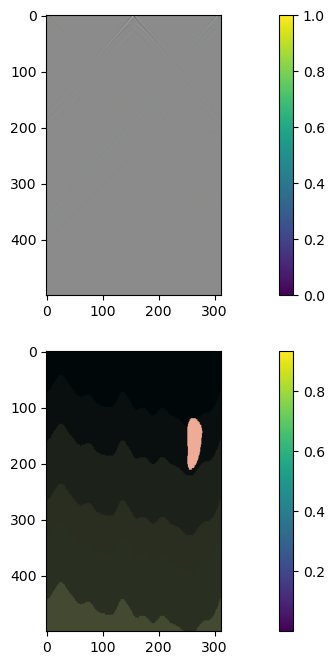

In [12]:
random_idx = random.randint(0, len(val_dataset) - 1)
image, target = train_dataset[random_idx]

image_np = tensor_to_image(image.squeeze(0))[:, :, :]  # Оригинальное изображение
target_np = tensor_to_image(target.squeeze(0))[:, :, :]  # Оригинальный таргет

# Рисуем результат
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)

plt.imshow(image_np[:, :, :3])
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(target_np)
plt.colorbar()

In [13]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight_factor=2.0, reduction="mean"):
        super(WeightedMSELoss, self).__init__()
        self.weight_factor = weight_factor
        self.reduction = reduction

    def forward(self, pred, target):
        # Вычисляем стандартный MSE
        loss = (pred - target) ** 2

        # Применяем взвешивание для пикселей, где target > 0.8
        weight = torch.where(target > 0.8, self.weight_factor, 1.0)
        loss = loss * weight

        # Применяем редукцию (по аналогии с MSELoss)
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none":
            return loss
        else:
            raise ValueError("Invalid reduction type. Choose from 'mean', 'sum', or 'none'.")

In [14]:
model = UNet_girafe(num_classes=3).to(device)
if CFG.USE_MULTIGPU and torch.cuda.device_count() > 1:
    print("Используем несколько GPU")
    model = nn.DataParallel(model)

Используем несколько GPU


In [15]:
import torch
import torch.nn as nn
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure


class SimpleSSIMLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure()

    def forward(self, preds, targets):
        return 1 - self.ssim(preds, targets)

In [16]:
class SSIM_MSE_Loss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.ssim = SimpleSSIMLoss().to(device)
        self.mse = nn.MSELoss().to(device)
        self.alpha = alpha  # вес для SSIM
        self.call_count = 0  # Счётчик вызовов

    def forward(self, preds, targets):
        return self.alpha * self.ssim(preds, targets) + (1 - self.alpha) * self.mse(preds, targets)

In [17]:
class SSIM_WeightedMSE_Loss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.ssim = SimpleSSIMLoss().to(device)
        self.mse = WeightedMSELoss(weight_factor=1.65, reduction="mean").to(device)
        self.alpha = alpha  # вес для SSIM
        self.call_count = 0  # Счётчик вызовов

    def forward(self, preds, targets):
        return self.alpha * self.ssim(preds, targets) + (1 - self.alpha) * self.mse(preds, targets)

In [18]:
from CFG import CFG

# criterion = nn.MSELoss()
criterion = SSIM_MSE_Loss(alpha=0.07)
# criterion = SSIM_WeightedMSE_Loss(alpha=0.07)
# criterion = WeightedMSELoss(weight_factor=1.65, reduction='mean')

optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)

train_losses, val_losses, val_ssim_scores = train_model(train_loader, val_loader, model, criterion, optimizer, device)

training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch     Train Loss     Val Loss       Val SSIM       Log Train Loss Log Val Loss   
  1/50      0.1042         0.0637         0.6391         -2.2612        -2.7530        
  2/50      0.0499         0.0413         0.7374         -2.9982        -3.1859        
  3/50      0.0384         0.0359         0.7691         -3.2589        -3.3264        
  4/50      0.0345         0.0343         0.7802         -3.3655        -3.3739        
  5/50      0.0324         0.0310         0.8031         -3.4296        -3.4732        
  6/50      0.0305         0.0305         0.8111         -3.4887        -3.4895        
  7/50      0.0292         0.0294         0.8186         -3.5320        -3.5273        
  8/50      0.0283         0.0284         0.8212         -3.5632        -3.5602        
  9/50      0.0282         0.0275         0.8248         -3.5698        -3.5924        
 10/50      0.0270         0.0280         0.8214         -3.6113        -3.5773        
 11/50      0.0260         0.0262 

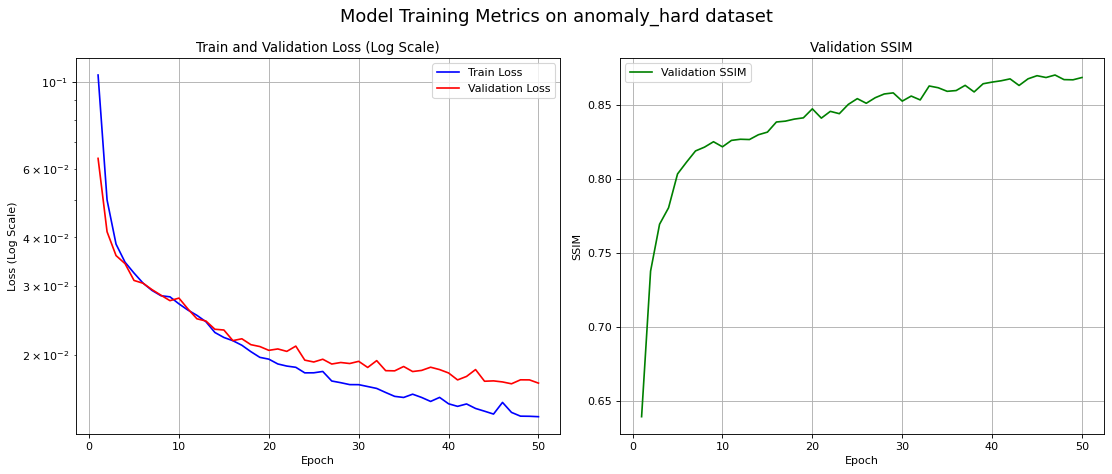

In [19]:
import matplotlib.pyplot as plt

# Создание 2-х субплотов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=80)

# Линия для train_losses и val_losses на первом субплоте с логарифмической шкалой
ax1.plot(
    range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="blue", linestyle="-"
)  # , marker='.')
ax1.plot(
    range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="red", linestyle="-"
)  # , marker='.')

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss (Log Scale)")
ax1.set_title("Train and Validation Loss (Log Scale)")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True)

# Линия для val_ssim_scores на втором субплоте без логарифмической шкалы
ax2.plot(
    range(1, len(val_ssim_scores) + 1), val_ssim_scores, label="Validation SSIM", color="green", linestyle="-"
)  # , marker='.')

ax2.set_xlabel("Epoch")
ax2.set_ylabel("SSIM")
ax2.set_title("Validation SSIM")
ax2.legend()
ax2.grid(True)

fig.suptitle(f"Model Training Metrics on {os.path.basename(BASE_PATH)} dataset", fontsize=16)

plt.tight_layout()
plt.show()

In [20]:
# best_model_path = "./models/best_model.pth"

# model = UNet()
# model = nn.DataParallel(model)

# model.load_state_dict(torch.load("models/best_model.pth"))
# model.to(device)

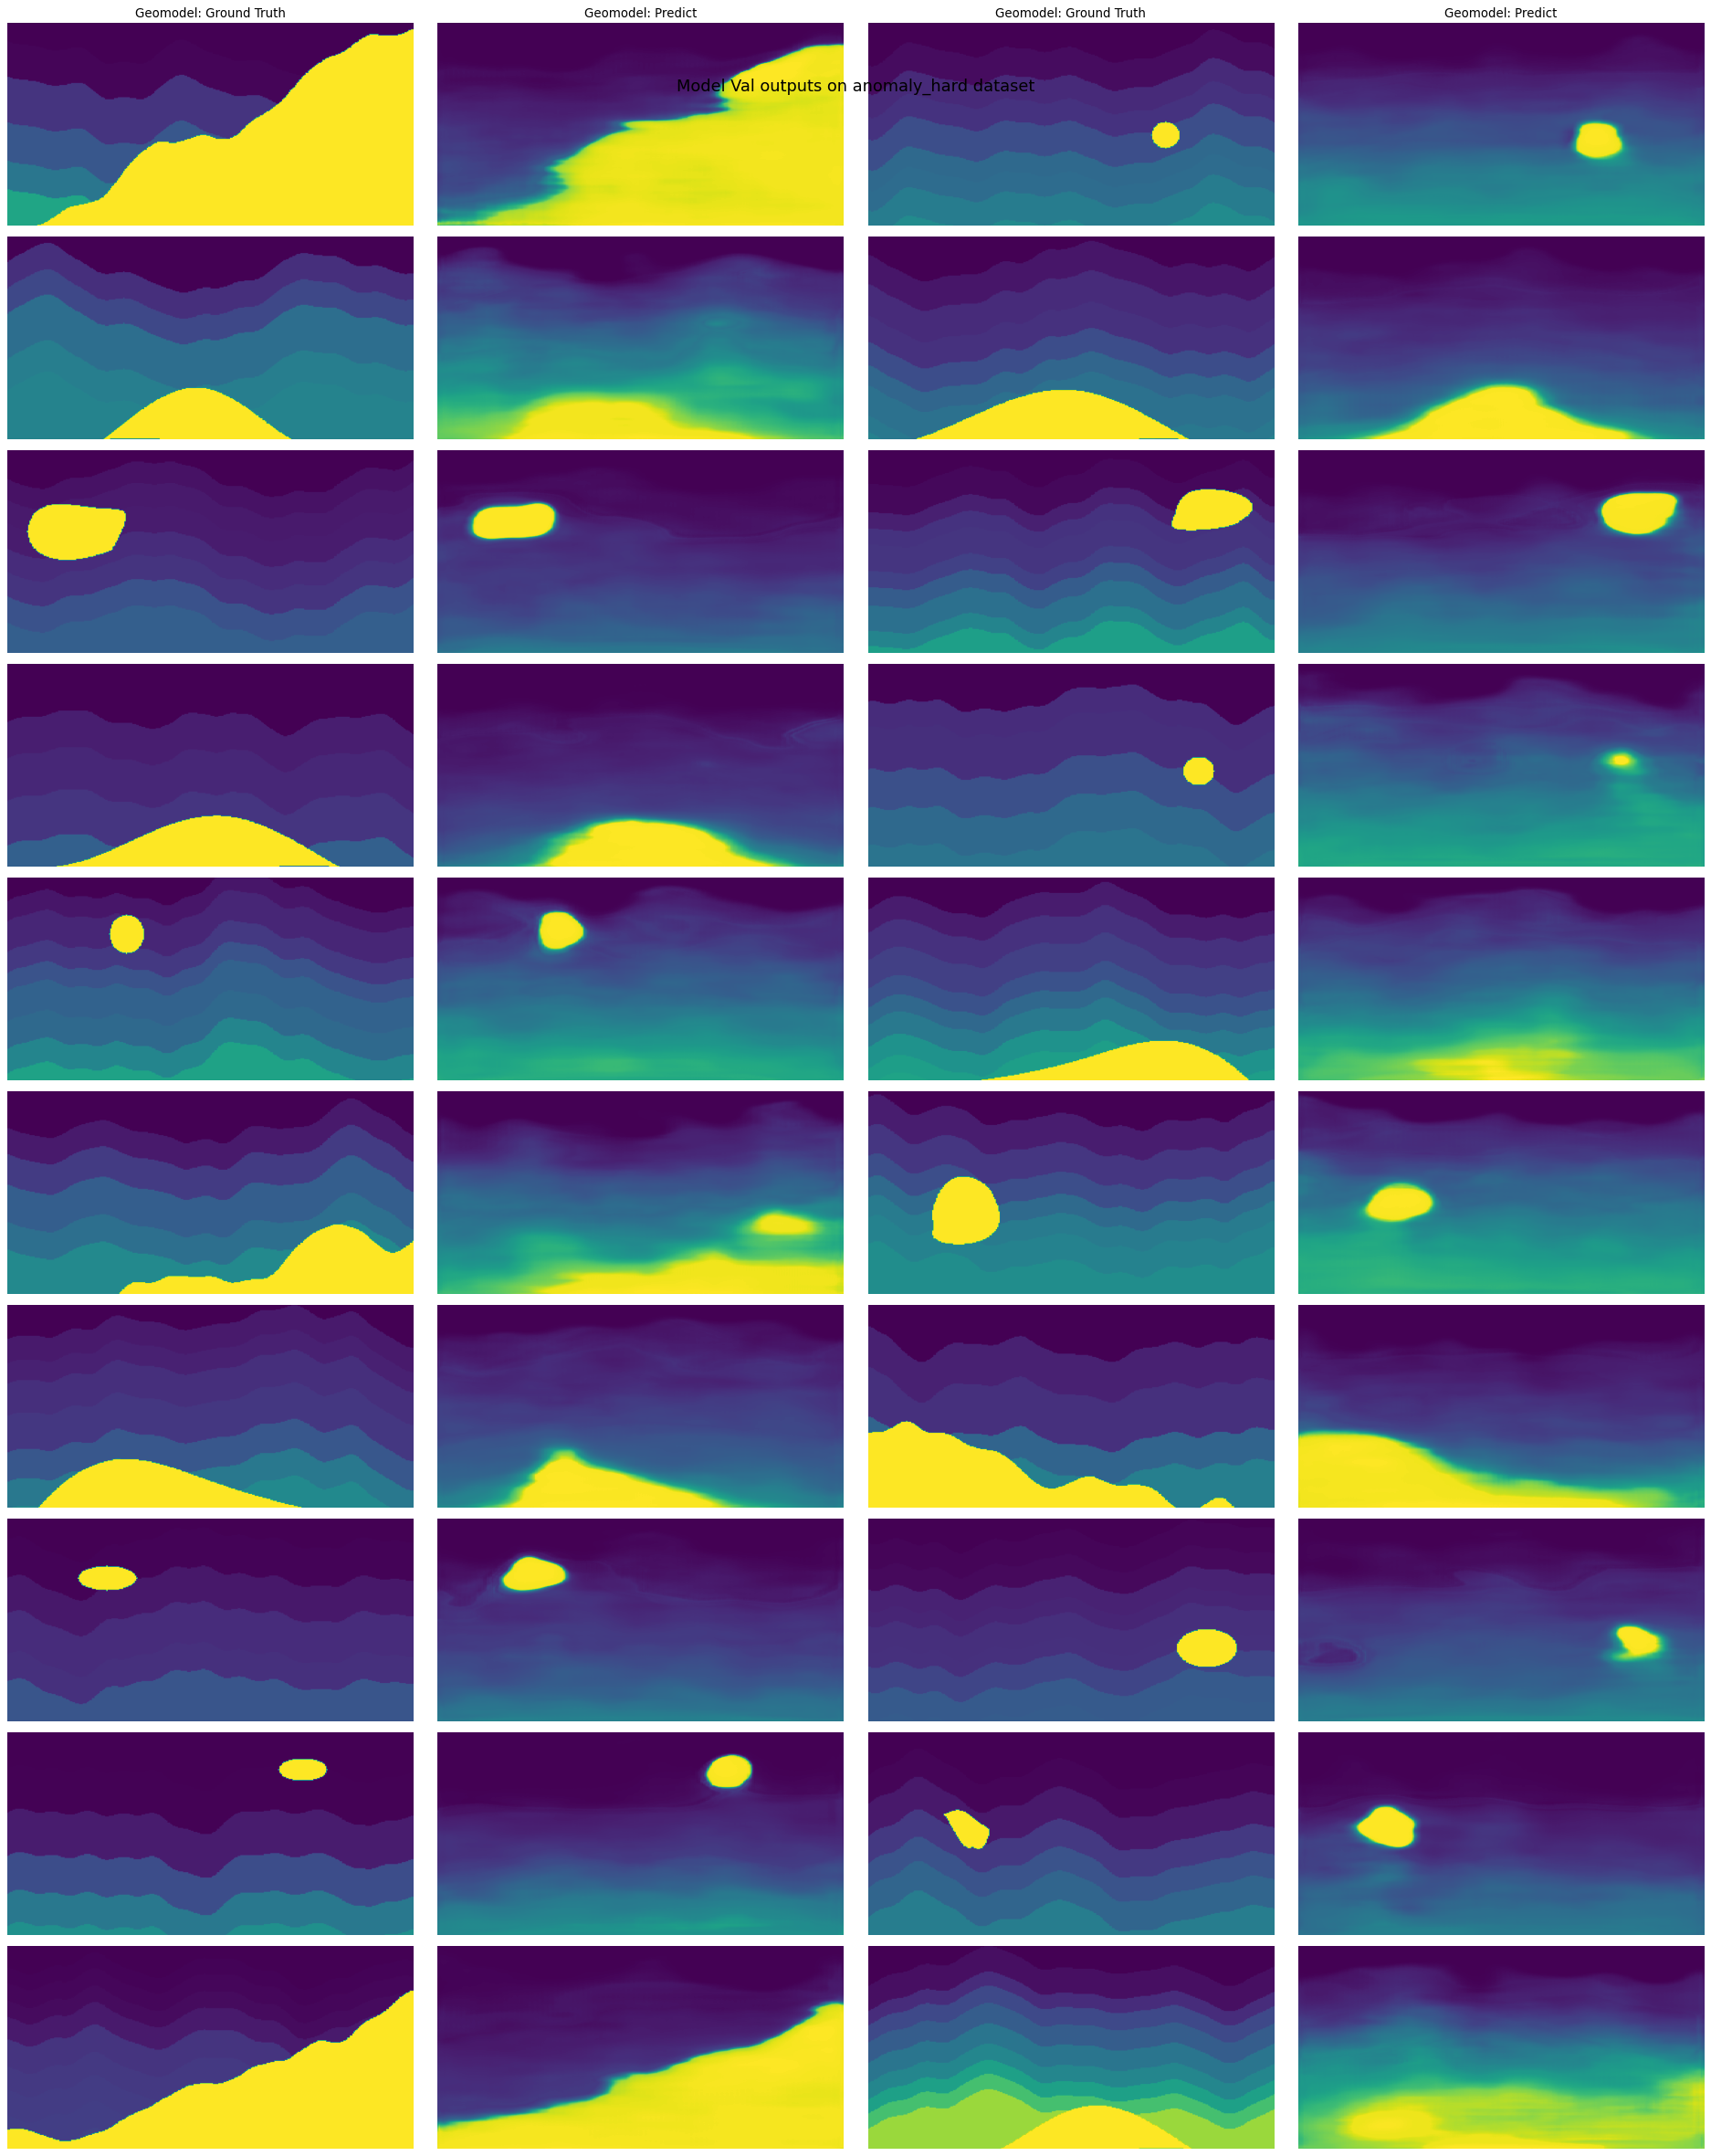

In [33]:
from visualizers import collect_predictions, visualize

num_samples = 20

indices = random.sample(range(len(val_dataset)), k=num_samples)
inputs, targets, outputs = collect_predictions(model, val_dataset, indices, device)

visualize(
    # (inputs, 'seismogram'),
    (targets[0:10], "target"),
    (outputs[0:10], "predict"),
    (targets[10:20], "target"),
    (outputs[10:20], "predict"),
    title=f"Model Val outputs on {os.path.basename(BASE_PATH)} dataset",
    use_log_norm=False,
)